In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [6]:
IMAGE_SIZE=256 # width * height
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset) # 69*32 is approximately equal to full length

68

In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape) # (number of immages,width,height,rgb)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 1 2 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 2 1 0]


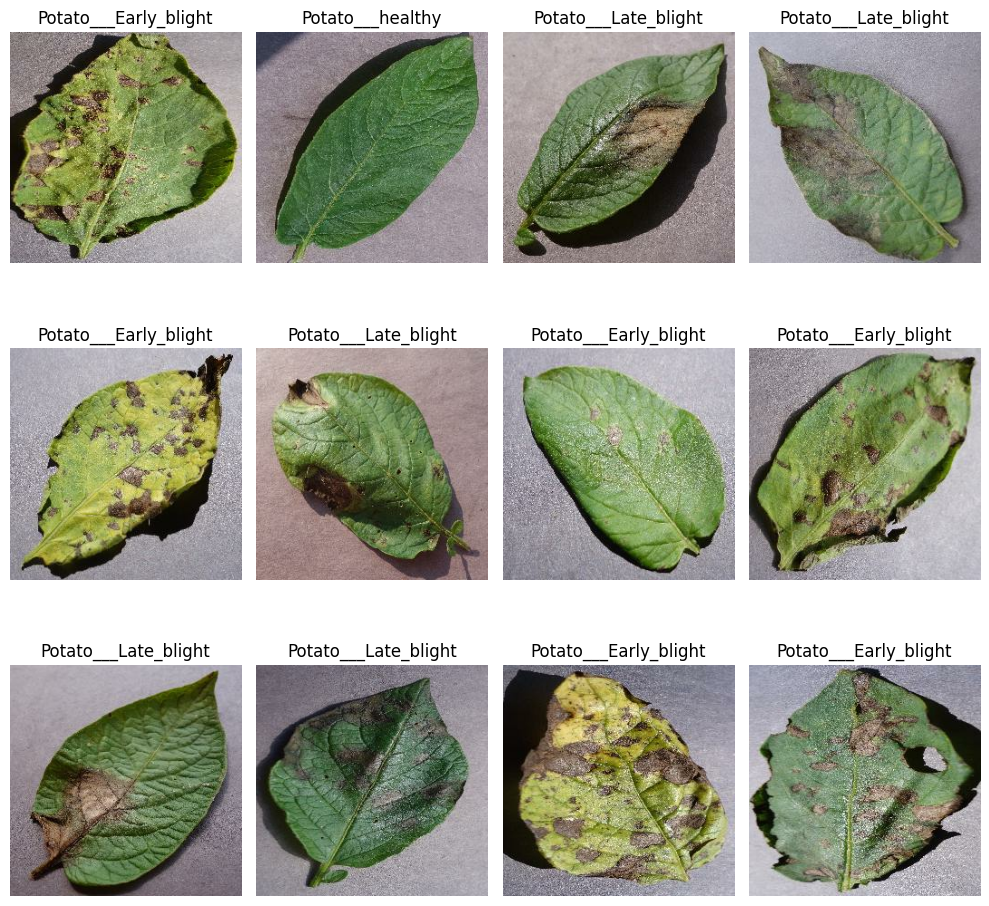

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))  # 3x4 grid for 12 images

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = axes.flat[i]
        ax.imshow(image_batch[i].numpy().astype('uint8'))
        ax.set_title(class_names[label_batch[i]])
        ax.axis("off")

plt.tight_layout()
plt.show()


In [12]:
def get_dataset_pratitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    test_size= int(test_split*ds_size)
    
    train_ds =ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_pratitions(dataset)

In [14]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# watch prefetach and cache tutorial in deep learning playlist

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # resize the image
    layers.Rescaling(1.0/255) # rescale the image between 0 and 1
])


In [17]:
#data augmentation - watch
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model =  models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape), # CNN layer
    layers.MaxPooling2D((2,2)), # Pooling layer
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')   
])

model.build(input_shape=input_shape)

D:\ML\code basics\potato_disease\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
) # train and stor details of each epochs

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.4616 - loss: 0.9640 - val_accuracy: 0.4740 - val_loss: 0.9486
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 684ms/step - accuracy: 0.4959 - loss: 0.8783 - val_accuracy: 0.6823 - val_loss: 0.6944
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 608ms/step - accuracy: 0.7355 - loss: 0.6053 - val_accuracy: 0.7865 - val_loss: 0.5067
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.8145 - loss: 0.4458 - val_accuracy: 0.8333 - val_loss: 0.3788
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.8224 - loss: 0.4028 - val_accuracy: 0.8229 - val_loss: 0.4000
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.9066 - loss: 0.2548 - val_accuracy: 0.8854 - val_loss: 0.2741
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.9188 - loss: 0.2026 - val_accuracy: 0.9323 - val_loss: 0.2163
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.9182 - loss: 0.2041 - val_accu

In [22]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9574 - loss: 0.1155


In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
history.history['accuracy']

[0.4826388955116272,
 0.5677083134651184,
 0.7471064925193787,
 0.8234953880310059,
 0.8368055820465088,
 0.9027777910232544,
 0.9085648059844971,
 0.9195601940155029,
 0.9502314925193787,
 0.9091435074806213,
 0.9473379850387573,
 0.9664351940155029,
 0.9577546119689941,
 0.9635416865348816,
 0.9733796119689941,
 0.9739583134651184,
 0.9681712985038757,
 0.9670138955116272,
 0.9756944179534912,
 0.9803240895271301,
 0.9716435074806213,
 0.9774305820465088,
 0.9774305820465088,
 0.9901620149612427,
 0.9571759104728699,
 0.9820601940155029,
 0.9809027910232544,
 0.9797453880310059,
 0.9913194179534912,
 0.9849537014961243,
 0.9924768805503845,
 0.9837962985038757,
 0.9918981194496155,
 0.9866898059844971,
 0.9837962985038757,
 0.9826388955116272,
 0.9774305820465088,
 0.9942129850387573,
 0.9895833134651184,
 0.9872685074806213,
 0.9826388955116272,
 0.9878472089767456,
 0.9884259104728699,
 0.9959490895271301,
 0.9953703880310059,
 0.9942129850387573,
 0.9936342835426331,
 0.9976851940

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =  history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

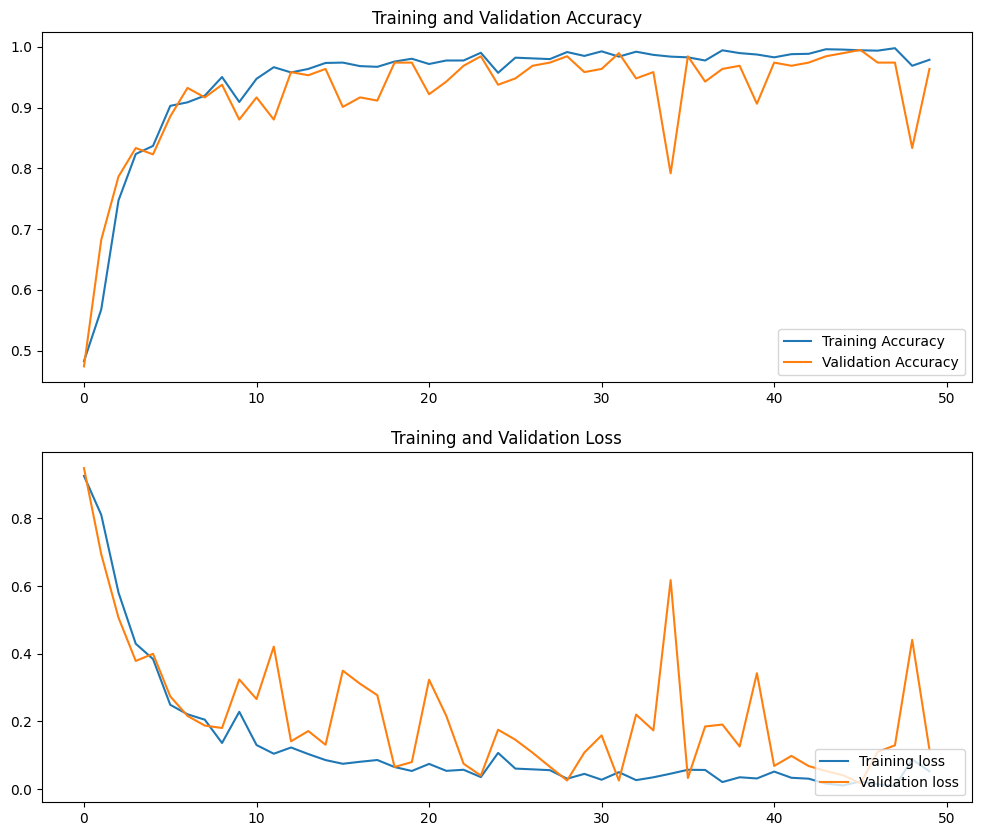

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0].plot(range(EPOCHS), acc, label='Training Accuracy')
axes[0].legend(loc='lower right')

axes[0].plot(range(EPOCHS), val_acc, label='Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_title("Training and Validation Accuracy")

print('\n')
axes[1].plot(range(EPOCHS), loss, label='Training loss')
axes[1].legend(loc='lower right')

axes[1].plot(range(EPOCHS), val_loss, label='Validation loss')
axes[1].legend(loc='lower right')
axes[1].set_title("Training and Validation Loss")


In [29]:
import numpy as np
np.argmax([0,5,2]) # return the index of maximum

np.int64(1)

First image to predict
First images's actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Potato___Late_blight


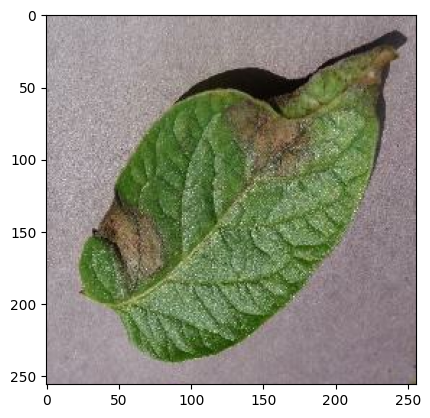

In [30]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First images's actual label: ",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])]) # Since we have dense layer with three neurons. So it gives three probabilities.
    # so we need to take maximm.

In [31]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence =  round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


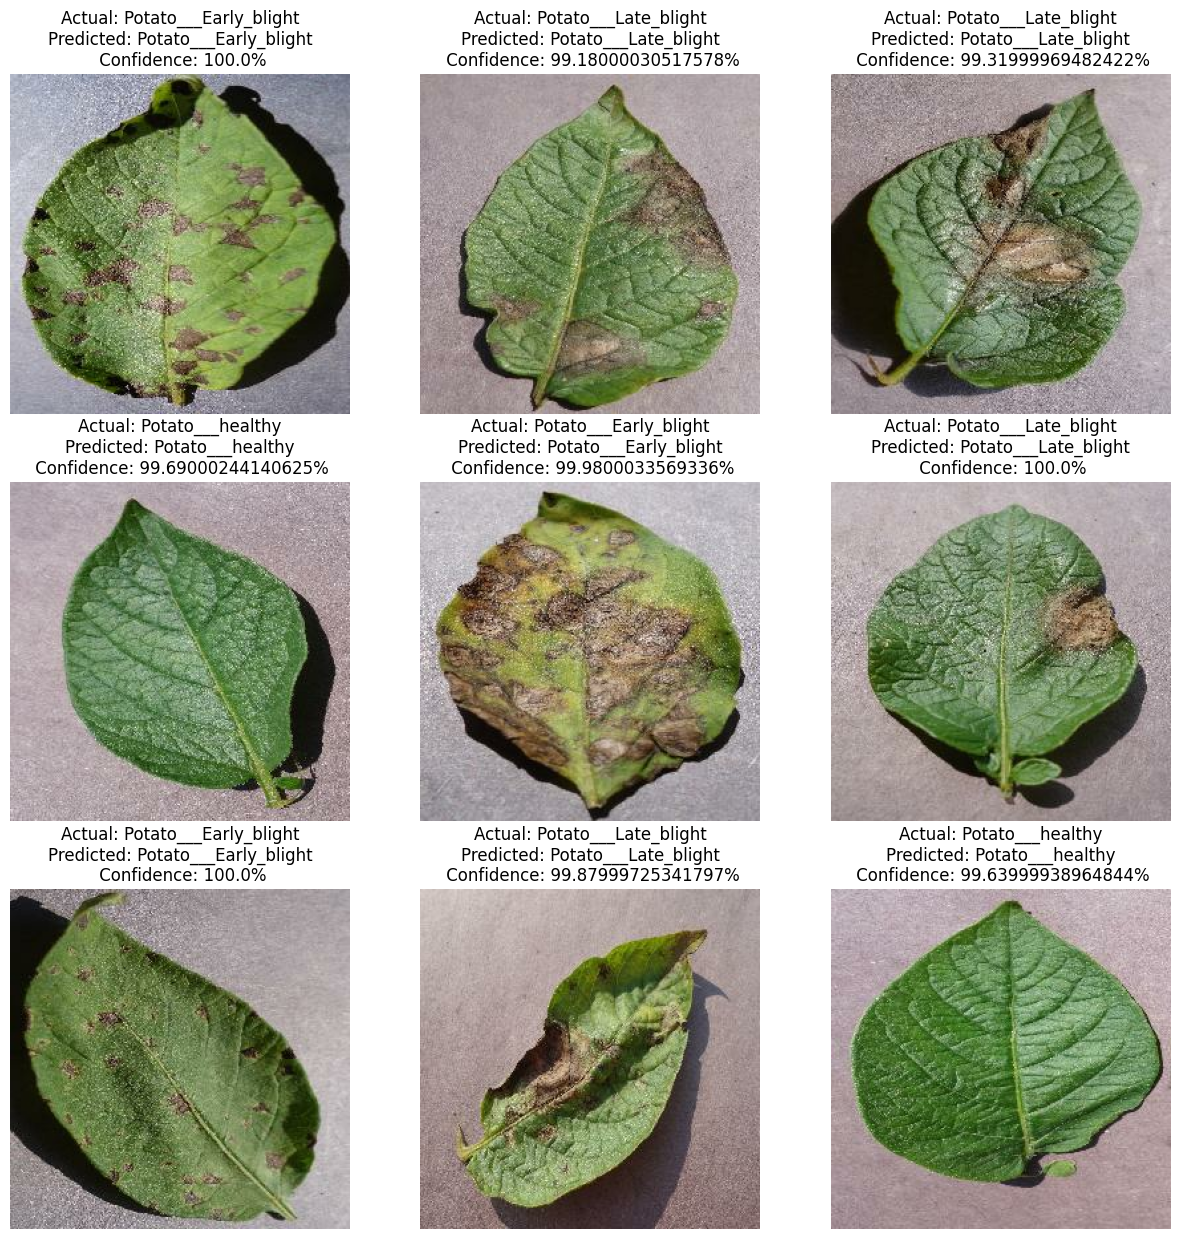

In [32]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\n Confidence: {confidence}%")
        
        plt.axis("off");

In [39]:
import os
files = os.listdir("../saved_models")
versions  = [ int(f.replace(".keras",'')) for f in files if f.endswith(".keras")]
versions

[1]

In [40]:
model_version= len(versions)+1
model.save(f"../saved_models/{model_version}.keras")
model.save(f"../saved_models/{model_version}.h5")
# model.save(f"../saved_models/{model_version}")